In [1]:
pip install git+https://github.com/qubvel/segmentation_models


  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-0_2ulsml
     |████████████████████████████████| 50 kB 811 kB/s eta 0:00:011
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33794 sha256=ea04d19e15eadf19202be2bd2a4fe1c326b0a066518b2eb35835f83d0a1d9cec
  Stored in directory: /tmp/pip-ephem-wheel-cache-e4d2jauu/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models
Note: you may need to restart the kernel to use updated packages.


In [2]:
!nvidia-smi

Thu Aug 27 05:00:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau,TensorBoard,EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model

from tensorflow.keras.applications.xception import Xception
import efficientnet.tfkeras as efn
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

['train.zip', 'train.csv', 'test.zip', 'sample-submission.csv']
Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


Работаем уже с Tensorflow 2.1

In [4]:
!pip freeze > requirements.txt

# Setup

In [5]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

EPOCHS               = 25
BATCH_SIZE           = 8
LR                   = 0.0001
VAL_SPLIT            = 0.15 #15%

CLASS_NUM            = 10
IMG_SIZE             = 224
#IMG_SIZE             = 250
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
dropout_rate = 0.2

DATA_PATH = '../input/'
PATH = "../working/car/"

In [6]:
# Setting seed for reproducibility
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [7]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

Id  Category
0  100155.jpg         0
1  100306.jpg         0
2  100379.jpg         0
3  100380.jpg         0
4  100389.jpg         0

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [9]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Всего выборка содержит 15561 обьект с 10 различными классами. Посмотрим на разбиение по классам:

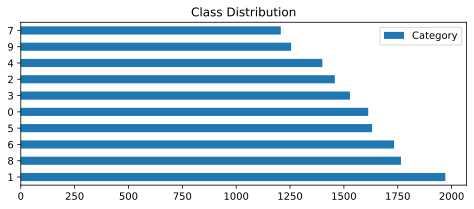

In [10]:
pd.DataFrame(train_df.Category.value_counts(sort=True)).plot(kind='barh',figsize=(8,3), title = 'Class Distribution')


В целом разбиение по классам сбалансировано. Наиболее частый класс - 1, наиболее редкий - 7

In [11]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


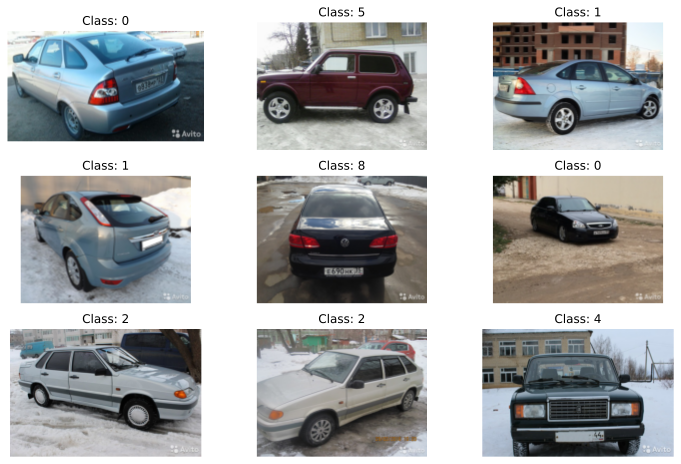

In [12]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Пример одной картинки


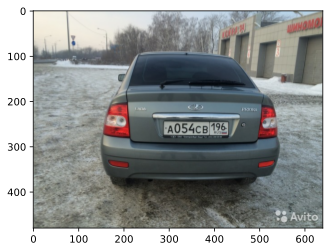

(640, 480)

In [13]:
print('Пример одной картинки')
image = PIL.Image.open(PATH+'/train/0/100389.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

Пример картинок (random sample) 1 класса


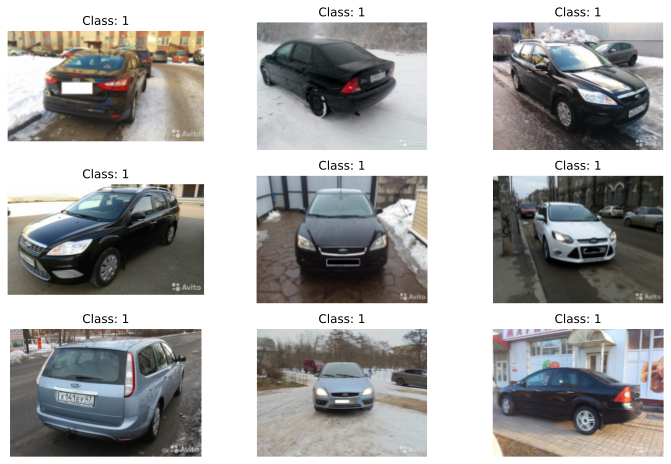

In [14]:
print('Пример картинок (random sample) 1 класса')
plt.figure(figsize=(12,8))

random_image = train_df[train_df['Category']==1].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Пример картинок (random sample) 7 класса


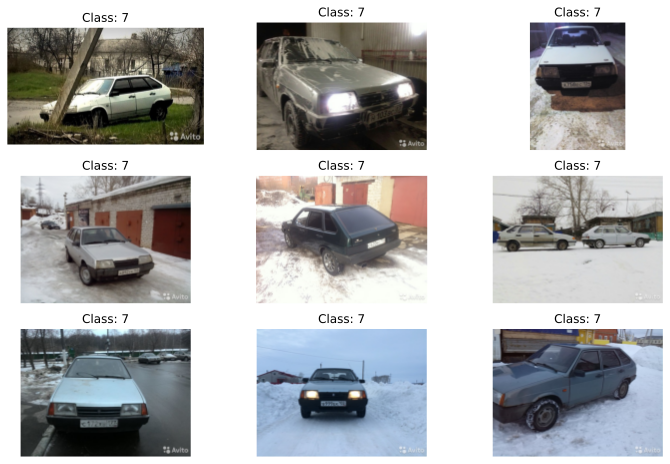

In [15]:
print('Пример картинок (random sample) 7 класса')
plt.figure(figsize=(12,8))

random_image = train_df[train_df['Category']==7].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

После ряда экспериментов визуально были выделены предположительные аналоги классов в датасете. Класс соответствует модели автомобиля.
ЧТо касается данных,то картинки имеют разный размер, разное положение авто и разную яркость. 

Стоит отметить, что в разметке данных есть некоторые неточности. В частности, это хорошо видно на примере 7 класса, где на фото могут присутствовать 2 автомобиля:

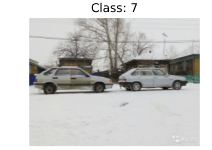

In [16]:
class_names = [
  '0_Приора', #0
  '1_Ford Focus', #1
  '2_Самара', #2
  '3_ВАЗ-2110', #3
  '4_Жигули', #4
  '5_Нива', #5
  '6_Калина', #6
  '7_ВАЗ-2109', #7
  '8_Volkswagen Passat', #8
  '9_ВАЗ-21099' #9
]

## Data Preparation
Важным этапом перед моделированием является работа с данными. Так как датасет не очень большой, будем использовать технику аугментации данных. Для этого предварительно попробуем сделать аугментацию с помощью keras.preprocessing imagedatagenerator, чтобы получить первые результаты. 

В дальнейших же экспериментах имеет смысл попробовать для аналогичной задачи воспользоваться библиотекой albumentations и посмотреть расширенный функционал, который она предлагает.

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #shear_range=0.1,
    #zoom_range=0.2,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False,
    #vertical_flip=True
)

test_datagen = ImageDataGenerator(rescale=1. / 255)


In [18]:
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# кстати, ты заметил, что для сабмишена мы используем другой источник для генератора flow_from_dataframe? 
# Как ты думаешь, почему?

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Пример картинок из train_generator


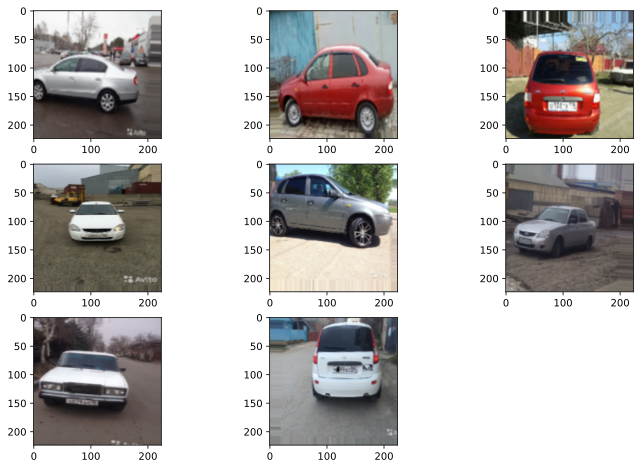

In [19]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,8):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()


Пример картинок из test_generator


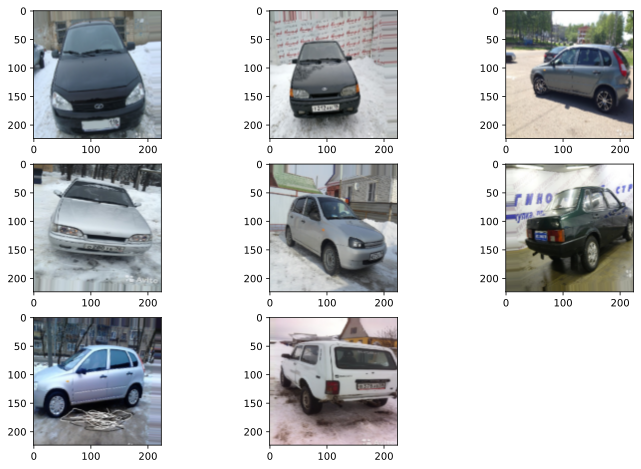

In [20]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,8):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Modeling

В качестве стартового решения задачи будем строить сеть не с нуля, а использовать уже предобученную на датасете imagenet модель. Датает Imagenet содержит картинки автомобилей, так что использование предобученной модели позволит работать с уже выхваченными текстурами.
По [ссылке](http://paperswithcode.com/sota/image-classification-on-imagenet) можно ознакомиться с современными лучшими практиками для решения рзличных классов задач.

В рамках текущего кернела за основу была выбрана сеть семейства EfficientNet (один из бенчмарков по точности).
Семейство efficientnet состоит из разных архитектур сетей. В качестве базового упражнения будут обучены 2 сети efficientNetB6(40М параметров) и efficientNetB5 (28М параметров).

Еще немного информации про [EfficientNet](http://medium.com/analytics-vidhya/image-classification-with-efficientnet-better-performance-with-computational-efficiency-f480fdb00ac6)

## Проверка сети EfficientNetB6

In [21]:
base_model_b6 = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

165527552/165527152 [==============================] - 4s 0us/step


In [22]:
base_model_b6.summary()

Model: "efficientnet-b6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 56) 1512        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 56) 0           stem_bn[0][0]                    
____________________________________________________________________________________

Total params: 40,960,136
Trainable params: 40,735,704
Non-trainable params: 224,432
__________________________________________________________________________________________________


### Transfer Learning B6

Воспользуемся техникой Transfer Learning согласно официальному туториалу: https://keras.io/guides/transfer_learning/

Для этого заморозим тело загруженной модели и будем обучать только новую голову

In [23]:
# Freeze the base_model
base_model_b6.trainable = False

In [24]:
x = base_model_b6.output

x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
#x = Dropout(dropout_rate, name="dropout_out")(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model_b6 = Model(inputs=base_model_b6.input, outputs=predictions)
model_b6.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [25]:
#inputs = keras.Input(shape=input_shape)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
#x = base_model_b6(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
#x = keras.layers.GlobalAveragePooling2D()(x)
#x = Dense(256, activation='sigmoid')(x)
#x = Dropout(dropout_rate)(x)
# A Dense classifier with a single unit (binary classification)
#outputs = keras.layers.Dense(CLASS_NUM, activation='softmax')(x)
#model_b6 = keras.Model(inputs, outputs)

#model_b6.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [26]:
model_b6.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 56) 1512        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 56) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [27]:
# https://keras.io/callbacks/
# model autosave callbacks
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')

# reduces learning rate on plateau
#lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown= 10,patience=30,verbose =1,min_lr=0.1e-5)

# stop learining as metric on validatopn stop increasing. (Останавливает обучение, в том случае когда валидационная метрика прекращает улучшаться).
early_stopping = EarlyStopping(monitor = 'val_accuracy',patience=30, restore_best_weights=True) 

# tensorboard for monitoring logs
tensorboard = TensorBoard(log_dir='./logs/tenboard', histogram_freq=0,write_graph=True, write_images=False)

#callbacks_list = [checkpoint,lr_reducer,early_stopping,tensorboard]


callbacks_list = [checkpoint,early_stopping, tensorboard]

In [28]:
# Обучение ок 2 часов
#history = model.fit_generator(
#        train_generator,
#        steps_per_epoch = len(train_generator),
#        validation_data = test_generator, 
#        validation_steps = len(test_generator),
#        epochs = EPOCHS,
#        callbacks = callbacks_list
#)

history = model_b6.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/25
1654/1654 [==============================] - ETA: 0s - loss: 1.6216 - accuracy: 0.4247
Epoch 00001: saving model to best_model.hdf5
1654/1654 [==============================] - 276s 167ms/step - loss: 1.6216 - accuracy: 0.4247 - val_loss: 1.1932 - val_accuracy: 0.5966
Epoch 2/25
1654/1654 [==============================] - ETA: 0s - loss: 1.2889 - accuracy: 0.5396
Epoch 00002: saving model to best_model.hdf5
1654/1654 [==============================] - 271s 164ms/step - loss: 1.2889 - accuracy: 0.5396 - val_loss: 1.0593 - val_accuracy: 0.6250
Epoch 3/25
1654/1654 [==============================] - ETA: 0s - loss: 1.1869 - accuracy: 0.5791
Epoch 00003: saving model to best_model.hdf5
1654/1654 [==============================] - 270s 163ms/step - loss: 1.1869 - accuracy: 0.5791 - val_loss: 0.9645 - val_accuracy: 0.6684
Epoch 4/25
1654/1654 [==============================] - ETA: 0s - loss: 1.1261 - accuracy: 0.6053
Epoch 00004: saving model to best_model.hdf5
1654/1654 [======

In [29]:
model_b6.save('../working/model_b6_base.hdf5')
model_b6.load_weights('best_model.hdf5')

In [30]:
scores = model_b6.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 41s 139ms/step - loss: 0.6145 - accuracy: 0.7836
Accuracy: 78.36%


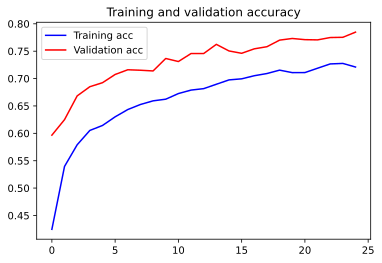

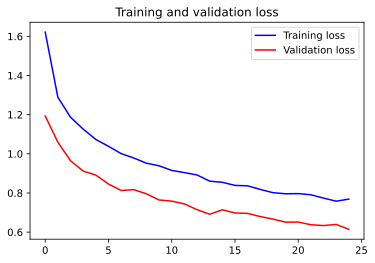

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Итоговая точность модели на тестовой выборке составила 78.36%, время обучения - порядка 2 часов. График показывает, что модель не переобучилась и возможно, имело смысл даже взять большее число эпох для обучения. Тем не менее, поскольку временные ресурсы на расчеты были ограничены, воспользуемся полученным результатом и попробуем его улучшить.

### Fine Tuning обученной модели B6

После обучения головы модели попробуем сделать так называемый Fine Tuning модели. Для этого пройдем небольшим learning rate по всей модели, чтобы дообучить признаки. Наконец, на финальном этапе, замерим, как изменилась точность.

In [32]:
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model_b6.trainable = True
model_b6.summary()

model_b6.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(1e-5), metrics=["accuracy"]) # Low learning rate

epochs = 15

history = model_b6.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = epochs,
        callbacks = callbacks_list
)


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 56) 1512        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 56) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

Total params: 41,552,786
Trainable params: 41,328,354
Non-trainable params: 224,432
__________________________________________________________________________________________________
Epoch 1/15
1654/1654 [==============================] - ETA: 0s - loss: 1.4573 - accuracy: 0.4821
Epoch 00001: saving model to best_model.hdf5
1654/1654 [==============================] - 508s 307ms/step - loss: 1.4573 - accuracy: 0.4821 - val_loss: 0.7613 - val_accuracy: 0.7199
Epoch 2/15
1654/1654 [==============================] - ETA: 0s - loss: 0.8798 - accuracy: 0.6799
Epoch 00002: saving model to best_model.hdf5
1654/1654 [==============================] - 501s 303ms/step - loss: 0.8798 - accuracy: 0.6799 - val_loss: 0.5104 - val_accuracy: 0.8153
Epoch 3/15
1654/1654 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.7633
Epoch 00003: saving model to best_model.hdf5
1654/1654 [==============================] - 501s 303ms/step - loss: 0.6677 - accuracy: 0.7633 - val_loss: 0.3839 

In [33]:
scores = model_b6.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 40s 137ms/step - loss: 0.1532 - accuracy: 0.9468
Accuracy: 94.68%


In [34]:
model_b6.save('../working/model_b6_ft.hdf5')
model_b6.load_weights('best_model.hdf5')

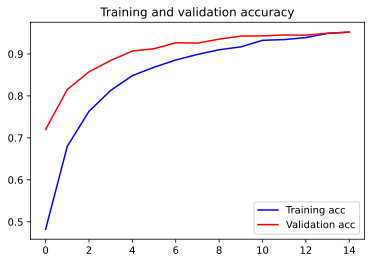

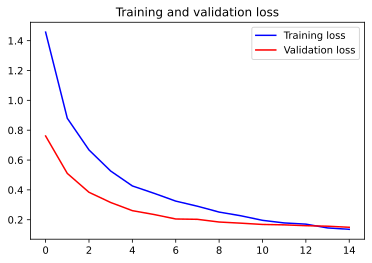

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Итоговая точность модели после fine-tuning'a повысилась и составила 94,68% (vs 78,36% только для головы). На графиках видно, что модель почти не переобучилась.

In [36]:
#reference https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Посмотрим детальнее на качество обученной модели:

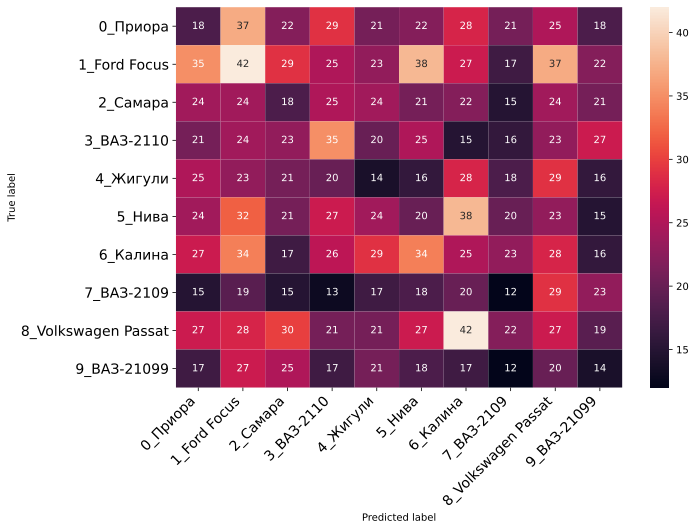

In [37]:
#Confution Matrix and Classification Report
Y_pred = model_b6.predict_generator(test_generator, test_generator.samples//test_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)

print_confusion_matrix(cm, class_names, figsize = (10,7), fontsize=14);

In [38]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

Classification Report
                     precision    recall  f1-score   support

           0_Приора       0.08      0.07      0.08       241
       1_Ford Focus       0.14      0.14      0.14       295
           2_Самара       0.08      0.08      0.08       218
         3_ВАЗ-2110       0.15      0.15      0.15       229
           4_Жигули       0.07      0.07      0.07       210
             5_Нива       0.08      0.08      0.08       244
           6_Калина       0.10      0.10      0.10       259
         7_ВАЗ-2109       0.07      0.07      0.07       181
8_Volkswagen Passat       0.10      0.10      0.10       264
        9_ВАЗ-21099       0.07      0.07      0.07       188

           accuracy                           0.10      2329
          macro avg       0.09      0.09      0.09      2329
       weighted avg       0.10      0.10      0.10      2329



## Проверка сети EfficientNetB6

In [39]:
base_model_b5 = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape=input_shape)

115515392/115515256 [==============================] - 1s 0us/step


### Transfer Learning B5

In [40]:
# Freeze the base_model
base_model_b5.trainable = False

In [41]:
inputs = keras.Input(shape=input_shape)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model_b5(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dropout(dropout_rate)(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(CLASS_NUM, activation='softmax')(x)
model_b5 = keras.Model(inputs, outputs)


model_b5.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [42]:
#x = base_model.output
#inputs = keras.Input(shape=input_shape)
#x = base_model(inputs, training=False)
#x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(256, activation='relu')(x)
#x = Dropout(0.25)(x)
#x = Dropout(dropout_rate, name="dropout_out")(x)
# and a logistic layer -- let's say we have 10 classes
#predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
#model = Model(inputs=base_model.input, outputs=predictions)
#model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [43]:
# https://keras.io/callbacks/
# model autosave callbacks
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')

# reduces learning rate on plateau
#lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown= 10,patience=30,verbose =1,min_lr=0.1e-5)

# stop learining as metric on validatopn stop increasing. (Останавливает обучение, в том случае когда валидационная метрика прекращает улучшаться).
early_stopping = EarlyStopping(monitor = 'val_accuracy',patience=30, restore_best_weights=True) 

# tensorboard for monitoring logs
tensorboard = TensorBoard(log_dir='./logs/tenboard', histogram_freq=0,write_graph=True, write_images=False)

#callbacks_list = [checkpoint,lr_reducer,early_stopping,tensorboard]


callbacks_list = [checkpoint,early_stopping, tensorboard]

In [44]:
#Обучение ок 2 часов
history = model_b5.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)


Epoch 1/25
1654/1654 [==============================] - ETA: 0s - loss: 1.6908 - accuracy: 0.4245
Epoch 00001: saving model to best_model.hdf5
1654/1654 [==============================] - 266s 161ms/step - loss: 1.6908 - accuracy: 0.4245 - val_loss: 1.3784 - val_accuracy: 0.5696
Epoch 2/25
1654/1654 [==============================] - ETA: 0s - loss: 1.2774 - accuracy: 0.5689
Epoch 00002: saving model to best_model.hdf5
1654/1654 [==============================] - 262s 158ms/step - loss: 1.2774 - accuracy: 0.5689 - val_loss: 1.1688 - val_accuracy: 0.6246
Epoch 3/25
1654/1654 [==============================] - ETA: 0s - loss: 1.1203 - accuracy: 0.6245
Epoch 00003: saving model to best_model.hdf5
1654/1654 [==============================] - 261s 158ms/step - loss: 1.1203 - accuracy: 0.6245 - val_loss: 1.0434 - val_accuracy: 0.6667
Epoch 4/25
1654/1654 [==============================] - ETA: 0s - loss: 1.0152 - accuracy: 0.6594
Epoch 00004: saving model to best_model.hdf5
1654/1654 [======

In [45]:
model_b5.save('../working/model_b5_base.hdf5')
model_b5.load_weights('best_model.hdf5')

In [46]:
scores = model_b5.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 39s 134ms/step - loss: 0.6319 - accuracy: 0.7797
Accuracy: 77.97%


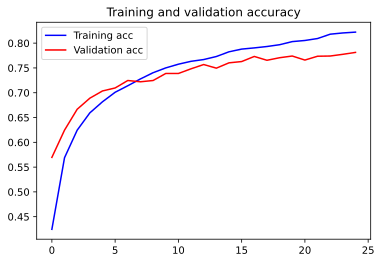

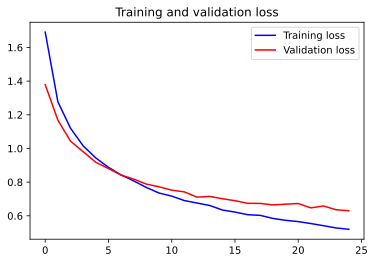

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Итоговая точность составила 77.97%, причем в отличие от EfficinetNetB6 сеть начала переобучаться. Попробуем аналогично улучшить результат за счет дообучения модели

### Fine Tuning обученной модели B5

In [48]:
base_model_b5.trainable = True
model_b5.summary()

model_b5.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(1e-5), metrics=["accuracy"]) # Low learning rate

epochs = 15

history = model_b5.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = epochs,
        callbacks = callbacks_list
)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 29,040,634
Trainable params: 28,867,898
Non-trainable params: 172,736
____________________________________

In [49]:
scores = model_b5.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 38s 131ms/step - loss: 0.3014 - accuracy: 0.9261
Accuracy: 92.61%


In [50]:
model_b5.save('../working/model_b6_ft.hdf5')
model_b5.load_weights('best_model.hdf5')

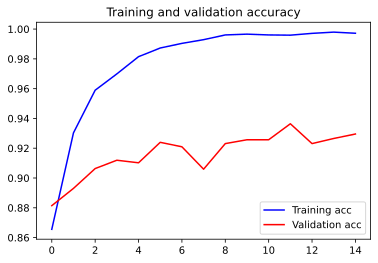

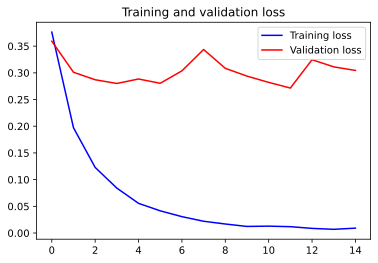

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Посмотрим аналогично на качество полученной модели

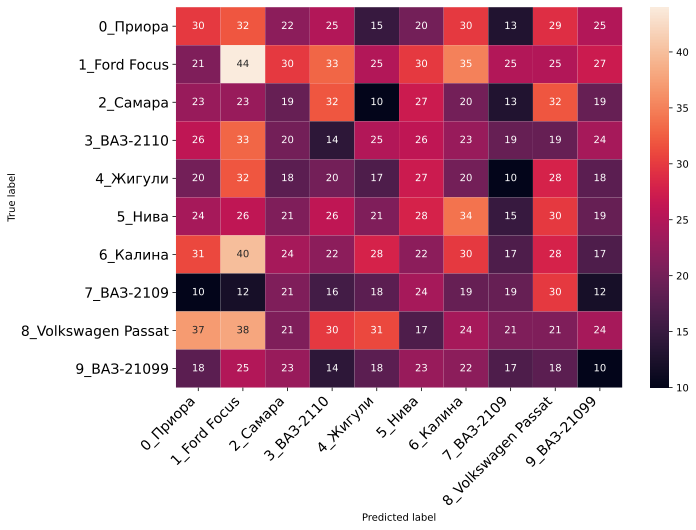

In [52]:
#Confution Matrix and Classification Report
Y_pred = model_b5.predict_generator(test_generator, test_generator.samples//test_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)

print_confusion_matrix(cm, class_names, figsize = (10,7), fontsize=14);

In [53]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

Classification Report
                     precision    recall  f1-score   support

           0_Приора       0.12      0.12      0.12       241
       1_Ford Focus       0.14      0.15      0.15       295
           2_Самара       0.09      0.09      0.09       218
         3_ВАЗ-2110       0.06      0.06      0.06       229
           4_Жигули       0.08      0.08      0.08       210
             5_Нива       0.11      0.11      0.11       244
           6_Калина       0.12      0.12      0.12       259
         7_ВАЗ-2109       0.11      0.10      0.11       181
8_Volkswagen Passat       0.08      0.08      0.08       264
        9_ВАЗ-21099       0.05      0.05      0.05       188

           accuracy                           0.10      2329
          macro avg       0.10      0.10      0.10      2329
       weighted avg       0.10      0.10      0.10      2329



Посмотрим на архитектуры получившихся сетей

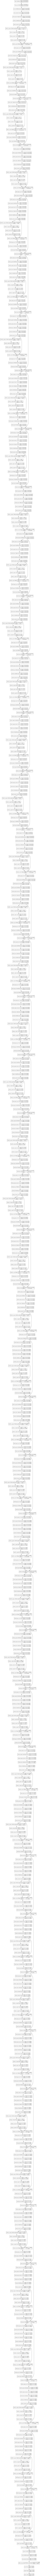

In [60]:
#рисуем архитектуру модели B6
keras.utils.plot_model(model_b6, 'multi_input_and_output_model_b6.png', show_shapes=True)

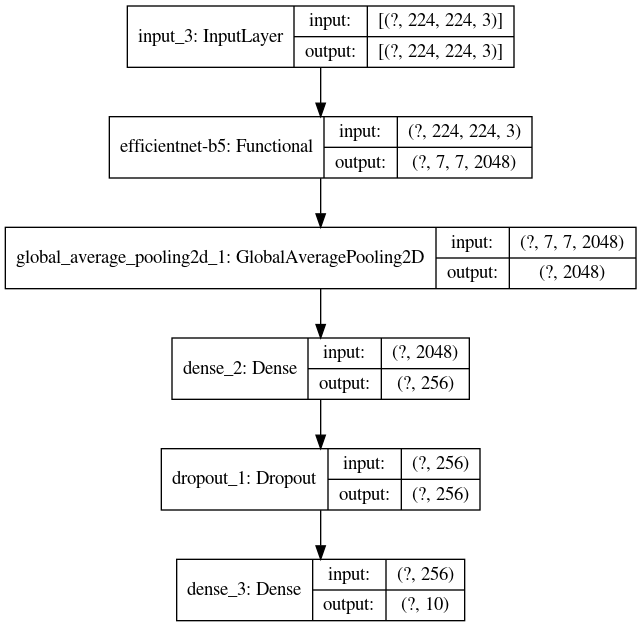

In [61]:
#рисуем архитектуру модели B5
keras.utils.plot_model(model_b5, 'multi_input_and_output_model_b5.png', show_shapes=True)

### Submission

In [62]:
test_sub_generator.samples

6675

In [63]:
test_sub_generator.reset()
predictions = model_b6.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

835/835 [==============================] - 55s 66ms/step


In [64]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [65]:
submission.head()

Id Category
0  305108.jpg        7
1  295075.jpg        6
2   31197.jpg        4
3   93598.jpg        7
4   87877.jpg        9

## Prediction Based on TTA

Качество модели на бае B6 оказалось ожидаемо лучше.Попробуем улучшить ее точность за счет техники TTA. Ниже дается краткое саммари метода:

* Data augmentation technique for the test dataset, where multiple augmentaed copies of images in dataset is created with zoom, flip and shifts

* The artificially expanded training dataset can result in a more skillful model, as often the performance of deep learning models continues to scale in concert with the size of the training dataset

* The model makes prediction for each and then ensemble of the predictions are returned

https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

UPD не сработало

In [ ]:
#test_datagen = ImageDataGenerator(rescale=1. / 255,
#                                 rotation_range = 90,
#                                    shear_range=0.2,
#                                    zoom_range=[0.75,1.25],
#                                    brightness_range=[0.5, 1.5],
#                                    width_shift_range=0.1,
#                                   height_shift_range=0.1,)
#test_generator = test_datagen.flow_from_directory(
#    PATH+'train/',
#    target_size=(IMG_SIZE, IMG_SIZE),
#    batch_size=BATCH_SIZE,
#    class_mode='categorical',
#    shuffle=True, seed=RANDOM_SEED,
#    subset='validation') # set as validation data


In [ ]:
#tta_steps = 10
#predictions = []

#for i in range(tta_steps):
#    preds = model.predict_generator(test_generator, verbose=1) 
#    predictions.append(preds)

#pred = np.mean(predictions, axis=0)

In [ ]:
#predictions = np.argmax(pred, axis=-1) #multiple categories
#label_map = (train_generator.class_indices)
#label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
#predictions = [label_map[k] for k in predictions]

In [ ]:
#filenames_with_dir=test_generator.filenames
#submission = pd.DataFrame({'Id':filenames_with_dir, 'Predict':predictions}, columns=['Id', 'Predict'])
#submission['Id'] = submission['Id'].replace('test_upload/','')
#submission.head()

In [ ]:
#поменять на кусок из теста subset validation
#tmp_y = pd.concat([submission['Predict'], train_df['Category']], axis=1, sort=False)

In [ ]:
#from sklearn.metrics import accuracy_score
#print('Accuracy: %.2f%%' % (accuracy_score(tmp_y['Category'], tmp_y['Predict'],)*100))

In [ ]:
#Подготовка файла для сабмита

#test_sub_generator = test_datagen.flow_from_dataframe(
#    dataframe=sample_submission,
#    directory=PATH+'test_upload/',
#    x_col="Id",
#    y_col=None,
#    shuffle=False,
#    class_mode=None,
#    seed=RANDOM_SEED,
#    target_size=(IMG_SIZE, IMG_SIZE),
#    batch_size=BATCH_SIZE,)

In [ ]:

#tta_steps = 10
#predictions = []

#for i in range(tta_steps):
#    preds = model.predict_generator(test_sub_generator, verbose=1) 
#    predictions.append(preds)

#pred = np.mean(predictions, axis=0)

In [ ]:
#predictions = np.argmax(pred, axis=-1) #multiple categories
#label_map = (train_generator.class_indices)
#label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
#predictions = [label_map[k] for k in predictions]
#filenames_with_dir=test_sub_generator.filenames

In [ ]:
#submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
#submission['Id'] = submission['Id'].replace('test_upload/','')
#submission.head()

In [ ]:
#submission.to_csv('submission_tta.csv', index=False)
#print('Save submit')

### Preparing for Inference

Официальный тюториал: https://keras.io/guides/serialization_and_saving/

https://docs.databricks.com/applications/machine-learning/model-inference/resnet-model-inference-keras.html

In [66]:
#Save the model
model_b6.save('model_final_b6.h5')
model_b5.save('model_final_b5.h5')
print('Models successfully saved!')

Models successfully saved!


In [59]:
# Clean PATH
#import shutil
#shutil.rmtree(PATH)

## Итоги и дополнительные эксперименты

В рамках реализации проекта помимо представленного в кернеле пайплайна были проведены следующие эксперименты:

* Использование библиотеки Albumentations для работы с аугментациями

* Использование TTA


Что можно было сделать лучше:

* Посвятить больше времени работе с данными и подбору аугментаций (данные - основа любого проекта), работе со сторонними библиотеками аугментаций
* Проверить сети других архитектур, например ResNext и тп согласно данным по лучшим практикам для соответствующего класса задач
* Добавить оптимизацию гиперпараметров (например, с помощью Talos) (заготовка кода приведена ниже)
* Выделить время и поэкспериментировать с инференсом модели, подготовкой прототипа н Streamlit

**Bonus. Optimisation draft**

https://github.com/autonomio/talos

За основу взят кернел https://www.kaggle.com/omodencode/keras-hyperparameter-optimization-heart-diease-uci

In [ ]:
#import talos as ts
#from keras.activations import relu, elu, selu, sigmoid, exponential, tanh

#p = {
#    'activation': [relu, elu, selu, sigmoid, exponential, tanh],
#    'batch_size': [64,128,256],
#   'First_Neron' : [64,128,256],
#    'Second_Neron' : [64,128,256],
#    'Third_Neron' : [64,128,256],
#    'epochs': [50,100,150,200]
#}


In [ ]:
#def get_model_talos(X_train,y_train,X_test,y_test,params):
#    model = Sequential() # load the sequential model
#    model.add(Dense(NB_CLASSES, input_shape=(13,), activation=params['activation'])) # add a dense layer
#    model.add(Dense(params['First_Neron'], input_shape=(13,), activation=params['activation']))
#    model.add(Dense(params['Second_Neron'], input_shape=(13,), activation=params['activation']))
#    model.add(Dense(params['Third_Neron'], input_shape=(13,), activation=params['activation']))
#    model.add(Dense(NB_CLASSES, input_shape=(13,))) # add a dense layer
#    model.add(Activation('softmax'))
    
#    model.compile(loss='binary_crossentropy', optimizer=SGD(), metrics=['accuracy'])
#    out = model.fit(X_train, y_train,
#                    epochs=params['epochs'],
#                    batch_size=params['batch_size'],
#                    validation_data=(X_test,y_test),
#                    verbose=0)
            
#    return out, model

In [ ]:
#t = ts.Scan(x=X_train_scaled, y=y_train_new, x_val=X_test_scaled, y_val=y_test_new, params=p, model=get_model_talos)

In [ ]:
#from talos import Reporting
#r = Reporting(t)

In [ ]:
#r.high()

In [ ]:
#ts.Deploy(t, 'car_class_predmodel');

In [ ]:
#car_class_predmodel = ts.Restore('car_class_predmodel.zip')